# spleeter 과정 제외한 음원 장르 분석 모델

### 필요한 패키지 임포트

In [20]:
import os
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import csv
import sklearn
from sklearn.preprocessing import MinMaxScaler

### 파일 경로 설정

In [2]:
general = "/content/drive"

audio_path = general + "/Othercomputers/MacBookAir/사운드"
# output_path = general + "/MyDrive/audio_output" -> 일단 만들어놓은 것

In [3]:
def song_names(audio_path):
    files = list(os.listdir(f'{audio_path}'))

    songs = []
    paths = []

    for file in files:
        song = f'{file}'
        path = f'{audio_path}/{file}'
        songs.append(song)
        paths.append(path)

    return songs, paths

In [4]:
songs, paths = song_names(audio_path)

In [5]:
print(songs)

['donttrustthedawn_sound.wav', 'goodbye_sound.wav', 'goodmorning_sound.wav', 'timelapse_sound.wav', 'wildflower_sound.wav']


In [6]:
paths

['/content/drive/Othercomputers/MacBookAir/사운드/donttrustthedawn_sound.wav',
 '/content/drive/Othercomputers/MacBookAir/사운드/goodbye_sound.wav',
 '/content/drive/Othercomputers/MacBookAir/사운드/goodmorning_sound.wav',
 '/content/drive/Othercomputers/MacBookAir/사운드/timelapse_sound.wav',
 '/content/drive/Othercomputers/MacBookAir/사운드/wildflower_sound.wav']

### librosa 활용해 음파 분석하기

In [7]:
y, sr = librosa.load(paths[0], duration = 30)
audio_file, _ = librosa.effects.trim(y)

In [8]:
len(audio_file) # -> length

652796

In [9]:
s_duration = 1 / sr
print(f"Duration of 1 sample is: {s_duration:.6f} seconds")

Duration of 1 sample is: 0.000045 seconds


In [10]:
duration = librosa.get_duration(audio_file, sr)     # s_duration * len(audio_file) 와 동일; 음원 전체 시간
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 29.61 seconds


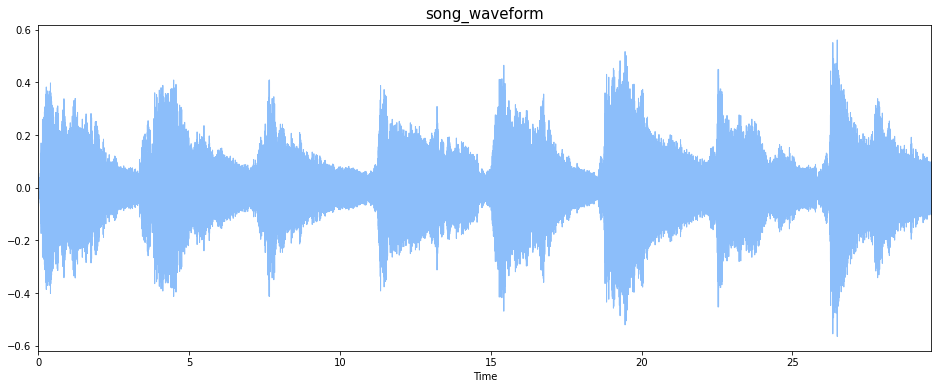

In [11]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = "#8cbefa");
plt.title("song_waveform", fontsize = 15);

In [12]:
n_fft = 2048 # FFT window size
hop_length = 512

stft = np.abs(librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length))

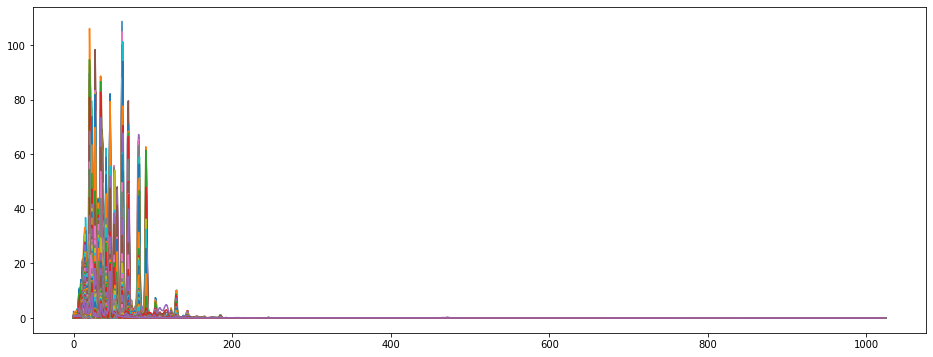

In [13]:
plt.figure(figsize=(16,6))
plt.plot(stft);

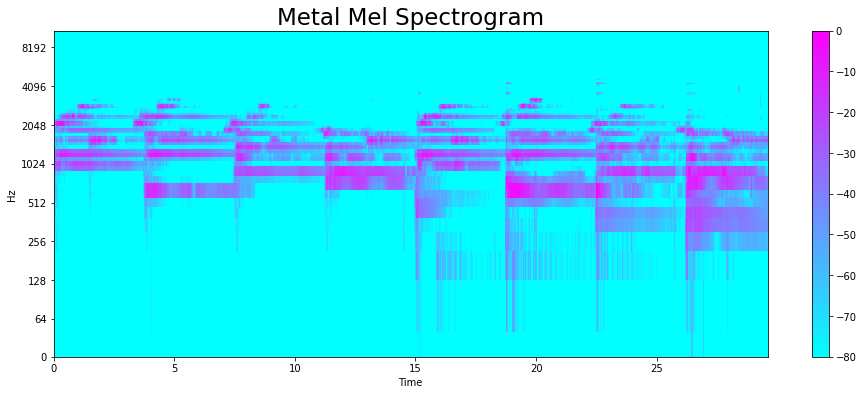

In [14]:
y, sr = librosa.load(paths[0], duration = 30)
audio_file, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(audio_file, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log', 
                         cmap = 'cool');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

In [15]:
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

26319


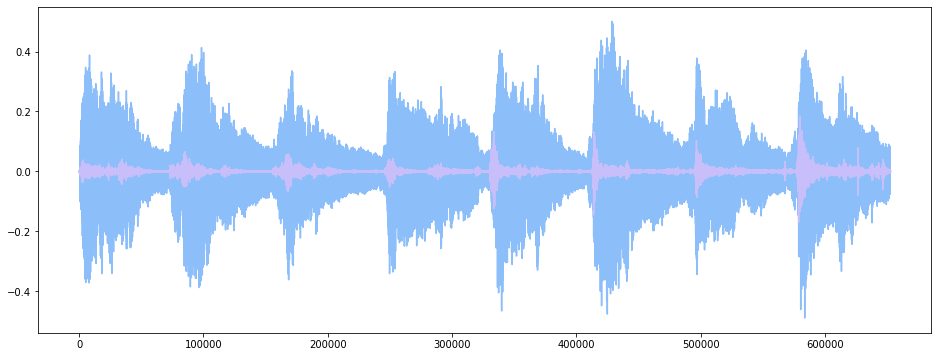

In [16]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#8cbefa'); # 연하늘 - 고조파 (인간의 귀가 들을 수 없는 영역)
plt.plot(y_perc, color = '#c8befa'); # 연보라

In [ ]:
#onset_env = librosa.onset.onset_strength(y=audio_file, sr=sr)
#tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
#tempo

Centroids: [621.9759685  598.32934101 572.36647423 ... 342.18167891 343.84293613
 504.55864616] 

Shape of Spectral Centroids: (1275,) 

frames: range(0, 1275) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.95357823e+01
 2.95590023e+01 2.95822222e+01]


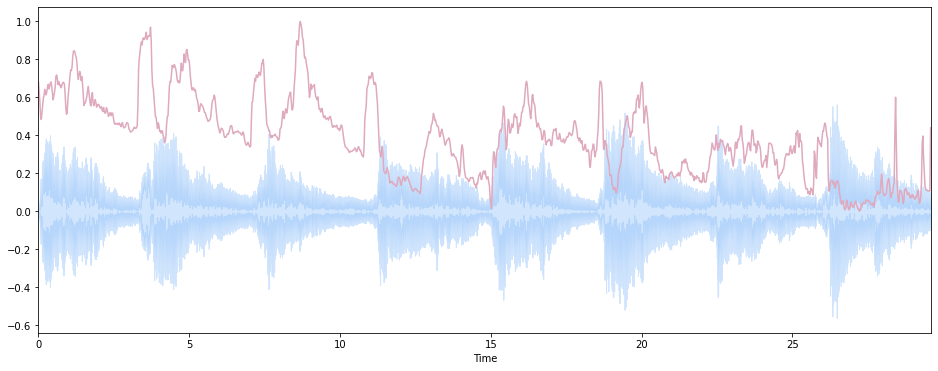

In [21]:
# Calculate the Spectral Centroids # 소리의 질량 중심 계산
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#8cbefa');
plt.plot(t, normalize(spectral_centroids), color='#dfa9be');

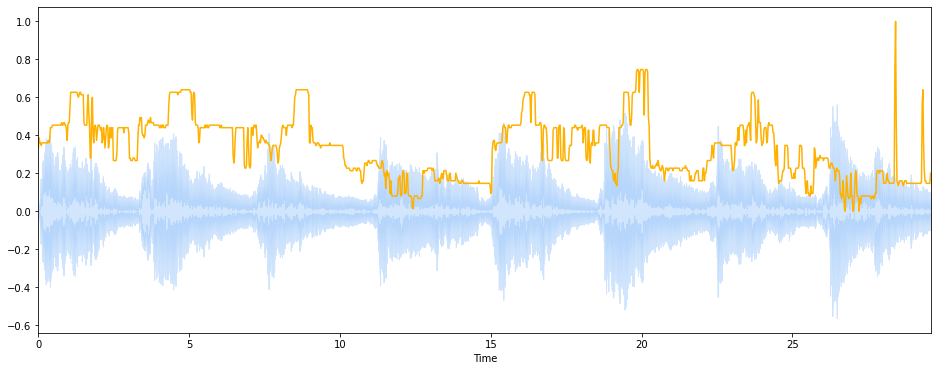

In [22]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#8cbefa');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

In [23]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
#plt.figure(figsize = (16, 6))
#librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

mfccs shape: (20, 1275)


In [24]:
mfccs_mean = []
mfccs_var = []
for mfcc in mfccs:
    mfcc_mean = mfcc.mean()
    mfcc_var = mfcc.var()
    mfccs_mean.append(mfcc_mean)
    mfccs_var.append(mfcc_var)

In [25]:
len(mfccs_mean), len(mfccs_var)

(20, 20)

Mean: 2.9919194e-09 

Var: 1.0


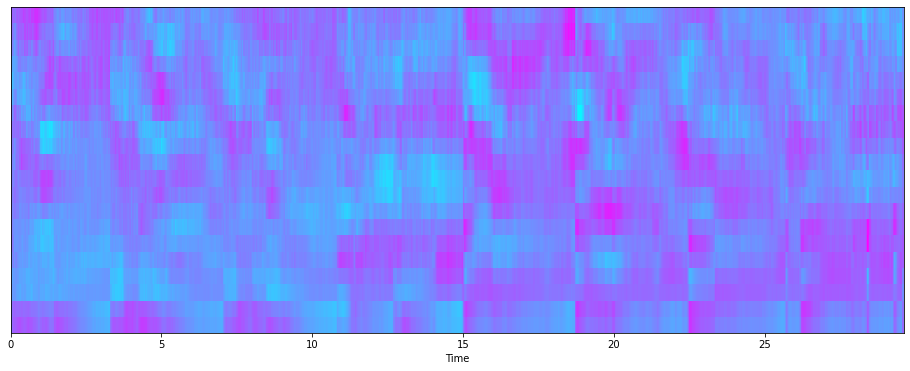

In [26]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

In [27]:
mfcc_all = {}

for i, mfcc in enumerate(mfccs):
    mfcc_all[i] = mfcc

In [28]:
mfcc_all

{0: array([-1.5186614 ,  0.07090063,  0.8208713 , ..., -0.9367488 ,
        -1.0534327 ,  0.75153846], dtype=float32),
 1: array([-1.7532841 , -0.02322272,  0.6458037 , ..., -0.6194581 ,
        -0.7857258 ,  0.58654994], dtype=float32),
 2: array([-0.27260575, -0.50181943, -0.79617625, ...,  0.97103715,
         0.9075233 , -0.35544536], dtype=float32),
 3: array([ 0.35406968, -0.75372255, -1.195827  , ...,  1.514467  ,
         1.5658307 ,  0.06058461], dtype=float32),
 4: array([ 0.6881748 , -0.14034858, -0.3936333 , ...,  1.4939321 ,
         1.6563928 ,  1.2756094 ], dtype=float32),
 5: array([0.9730733, 0.7732623, 0.4386794, ..., 0.9700161, 1.1259191,
        1.3944683], dtype=float32),
 6: array([1.0780429 , 0.8693894 , 0.4605984 , ..., 0.60093784, 0.64496684,
        1.1530353 ], dtype=float32),
 7: array([0.6687802 , 0.5438861 , 0.3327927 , ..., 0.17335798, 0.05952512,
        0.96780545], dtype=float32),
 8: array([-0.03350308,  0.22483067,  0.17487618, ..., -0.39031726,
    

Chromagram shape: (12, 131)


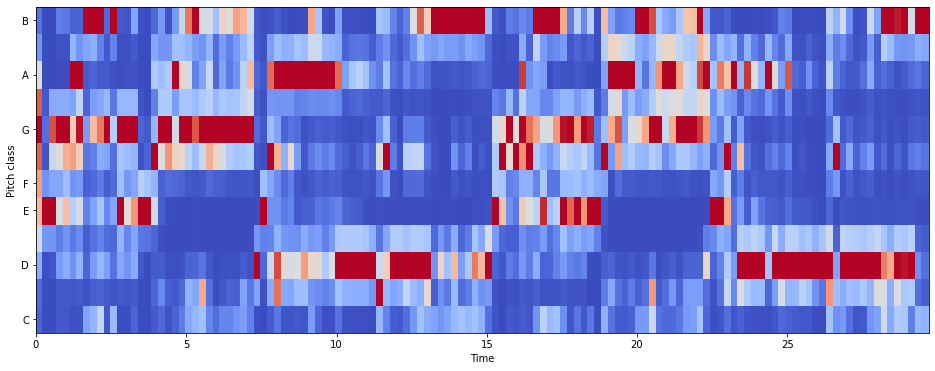

In [29]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromagram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

### 함수화 하기

In [30]:
import os

general = "/content/drive"
audio_path = general + "/Othercomputers/MacBookAir/사운드"
output_path = general + "/MyDrive/audio_output"

In [31]:
# filename 함수 -> songs 가 노래제목들의 리스트
def song_names(audio_path):                      # audio_path : 음원 파일들의 폴더 경로
    files = list(os.listdir(f'{audio_path}'))

    songs = []
    paths = []

    for file in files:
        song = f'{file}'
        path = f'{audio_path}/{file}'
        songs.append(song)
        paths.append(path)

    return songs, paths

In [32]:
# 음원 업로드 using Librosa
# length 함수 = len(audio_file) 
def soundwave(paths):
    audio_files = []

    for path in paths:
        y, sr = librosa.load(path, duration = 60)
        y, _ = librosa.effects.trim(y)
        audio_files.append(y)

    return audio_files, sr                      # sr 디폴트 : 22050 / 변경 가능한 sr 수치 : 44100

In [33]:
from librosa.feature.spectral import chroma_cens
# chroma_stft_mean, chroma_stft_var 함수 / chromagram.mean(), chromagram.var()
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
def chromagram(audio_file, sr, hop_length):
    chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length).ravel()

    return chromagram

In [34]:
# rms_mean, rms_var 함수

def rms(audio_file, frame_length, hop_length):
    rms = librosa.feature.rms(audio_file).ravel()

    return rms

In [35]:
# spectral_centroid_mean, spectral_centroid_var 함수

def spectral_centroid(audio_file, sr):
    centroid = librosa.feature.spectral_centroid(audio_file, sr=sr).ravel()

    return centroid

In [36]:
# spectral_bandwidth_mean, spectral_bandwidth_var 함수

def bandwidth(audio_file, sr):
    bandwidth = librosa.feature.spectral_bandwidth(audio_file, sr=sr).ravel()

    return bandwidth

In [37]:
# rolloff_mean, rolloff_var 함수

def rolloff(audio_file, sr):
    rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr).ravel()

    return rolloff

In [38]:
# zero_crossing_rate_mean, zero_crossing_rate_var 함수

def zcr(audio_file):
    zcr = librosa.feature.zero_crossing_rate(audio_file).ravel()

    return zcr

In [39]:
# harmony_mean, harmony_var 함수 / y_harm.mean(), y_harm.var()
# perceptr_mean, perceptr_var / y_perc.mean(), y_perc.var()

def harm_perc(audio_file):
    harm, perc = librosa.effects.hpss(audio_file)

    return harm, perc

In [40]:
def flux(audio_file, sr):
    flux = librosa.onset.onset_strength(audio_file, sr=sr).ravel()

    return flux

In [41]:
def contrast(audio_file, sr):
    contrast = librosa.feature.spectral_contrast(audio_file, sr=sr).ravel()

    return contrast

In [42]:
def flatness(audio_file):
    flatness = librosa.feature.spectral_flatness(audio_file).ravel()

    return flatness

In [43]:
# tempo 함수

def tempo(audio_file, sr):
    onset_env = librosa.onset.onset_strength(y=audio_file, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)

    return tempo

In [44]:
# mfcc 1 ~ 20 # n_fft 가 디폴트 20인듯 -> 이것을 하나씩 추출

def mfcc(audio_file, sr):
    mfccs = librosa.feature.mfcc(audio_file, sr=sr)
    mfccs = sklearn.preprocessing.scale(mfccs, axis=1)

    mfcc_all = {}

    for i, mfcc in enumerate(mfccs):
        mfcc_all[i] = mfcc.ravel()

    return mfcc_all

### 음파 피쳐값 df 만들기

In [45]:
def get_features(y, sr):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None, 'chroma_stft': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['chroma_stft']=librosa.feature.chroma_stft(y=y, sr=sr).ravel()
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr,).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y).ravel()
    features['rmse'] = librosa.feature.rms(y).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y).ravel()
    
    # harmony, perceptral treatment (+@ 부분)
    harm, perc = librosa.effects.hpss(y)
    features['harm'] = harm.ravel()
    features['perc'] = perc.ravel()

    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, sr=sr)   # n_mfcc=20 (default) 
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
#    onset_env = librosa.onset.onset_strength(y=audio_file, sr=sr)
#    dict_agg_features['tempo'] = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]

    return dict_agg_features

In [46]:
def final_extraction(dataset_dir=audio_path):
#    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    last_features=[]

    songs, paths = song_names(audio_path)
    audio_files, sr = soundwave(paths)

    for audio in audio_files:
        features = get_features(audio, sr)
        last_features.append(features)
    return pd.DataFrame(last_features)

In [47]:
%%time

df_features = final_extraction()

CPU times: user 40.6 s, sys: 2.37 s, total: 43 s
Wall time: 44.7 s


In [48]:
# export the data to a csv file
df_features.to_csv('Data.csv', index=False)

In [49]:
# import the data
df_features = pd.read_csv('Data.csv')

In [50]:
df_features

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo
0,4770.576476,147.877628,537.633031,488.240796,31.902617,5.412102,8591.748047,193.798828,829.326111,1062.228696,...,9.537965,0.101890,0.259081,32.933700,-33.396280,-4.979070,10.530147,-0.016696,0.283850,123.046875
1,908.569644,326.772485,566.823380,96.506892,-0.254790,0.016370,2002.587891,495.263672,930.468578,182.601987,...,9.587304,0.182229,-0.226135,26.164366,-34.581207,-7.516415,10.248731,-0.495890,0.072928,95.703125
2,5025.185530,157.374058,1407.873315,911.827190,0.649020,1.084272,9302.343750,118.432617,3051.481988,2372.126604,...,11.190249,-0.229197,0.051315,25.897486,-47.458940,-4.988096,10.317096,1.159996,-0.471385,86.132812
3,4143.256610,373.214565,1432.712155,512.005474,1.676911,0.756034,7568.920898,430.664062,2976.247002,1339.364612,...,8.298755,0.688311,0.505163,23.312233,-29.086233,-6.071716,8.933170,-0.340493,-0.008454,129.199219
4,3914.887835,332.882843,795.306111,393.694988,4.989771,2.008197,6815.258789,473.730469,1482.228753,1011.831476,...,7.554245,0.334192,-0.348806,15.173370,-25.707623,-5.705788,6.344338,0.020395,0.174523,129.199219


In [51]:
list(df_features.columns)

['centroid_max',
 'centroid_min',
 'centroid_mean',
 'centroid_std',
 'centroid_kurtosis',
 'centroid_skew',
 'roloff_max',
 'roloff_min',
 'roloff_mean',
 'roloff_std',
 'roloff_kurtosis',
 'roloff_skew',
 'flux_max',
 'flux_min',
 'flux_mean',
 'flux_std',
 'flux_kurtosis',
 'flux_skew',
 'rmse_max',
 'rmse_min',
 'rmse_mean',
 'rmse_std',
 'rmse_kurtosis',
 'rmse_skew',
 'zcr_max',
 'zcr_min',
 'zcr_mean',
 'zcr_std',
 'zcr_kurtosis',
 'zcr_skew',
 'contrast_max',
 'contrast_min',
 'contrast_mean',
 'contrast_std',
 'contrast_kurtosis',
 'contrast_skew',
 'bandwidth_max',
 'bandwidth_min',
 'bandwidth_mean',
 'bandwidth_std',
 'bandwidth_kurtosis',
 'bandwidth_skew',
 'flatness_max',
 'flatness_min',
 'flatness_mean',
 'flatness_std',
 'flatness_kurtosis',
 'flatness_skew',
 'chroma_stft_max',
 'chroma_stft_min',
 'chroma_stft_mean',
 'chroma_stft_std',
 'chroma_stft_kurtosis',
 'chroma_stft_skew',
 'sample_silence_max',
 'sample_silence_min',
 'sample_silence_mean',
 'sample_silenc